This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments2'
imageroot = '20200624_case1.0'
Calibrationfile = '../Case1.0 (calibration)/Calibration.nml'

/Users/nesh/Documents/repositories/ice2020/crystals/2020-06-24/Run 1/case1.0 (calibration)
2020-06-24/Run 1/case1.0 (calibration)


In [4]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments2_retrieved.npz
Segments2_roughness.jpg
Segments2_roughness.txt


In [5]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [6]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20200624_case1.0-A.bmp
SEMimages/20200624_case1.0-B.bmp
SEMimages/20200624_case1.0-C.bmp
SEMimages/20200624_case1.0-D.bmp
Filename, dx and dy SEMimages/20200624_case1.0-D.bmp 0.7087054 0.7087054


In [7]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 8.728483967253755
Correlation of detectors A-D for each segment
for segment  0
nx= 36
ny= 36
0 1 -14.584211697075864
0 2 -84.5181226348814
0 3 -70.82159833147698
1 2 -9.767278066928057
1 3 -18.429328752219032
2 3 90.05899757127432
Correlation score = 144.62839969180288



<IPython.core.display.Javascript object>


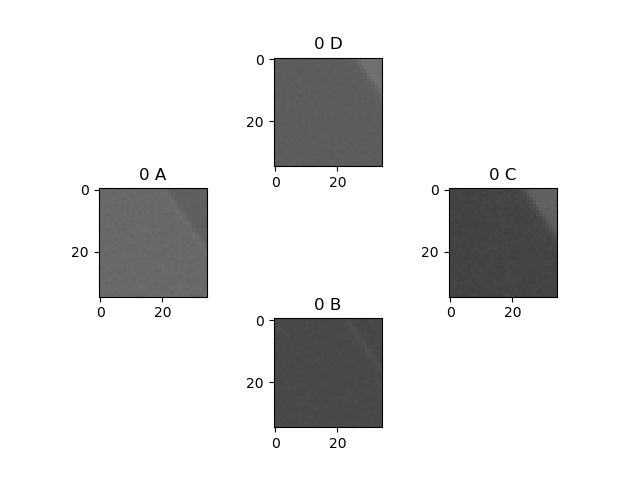

for segment  1
nx= 36
ny= 36
0 1 3.1420025538804484
0 2 -0.04840203291442232
0 3 -4.226840773757506
1 2 -1.510770311774967
1 3 1.8345651907308795
2 3 4.654481473182395
Correlation score = 7.419768183054015



<IPython.core.display.Javascript object>


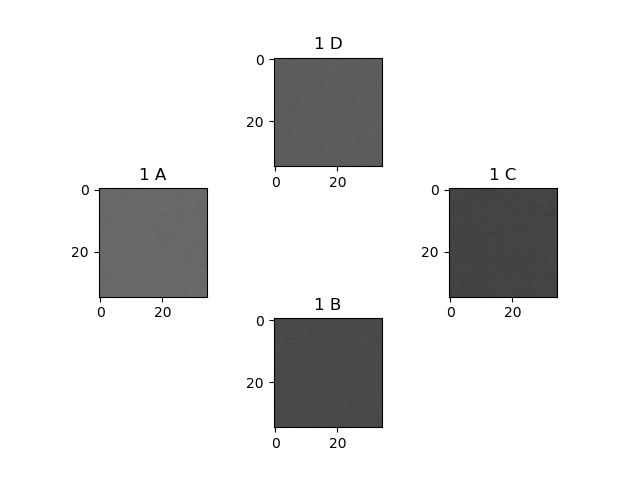

for segment  2
nx= 36
ny= 36
0 1 6.567029718851409
0 2 0.40476827080815625
0 3 -0.26448838771522754
1 2 9.437345980021508
1 3 -0.2849153172329637
2 3 1.5165693650871162
Correlation score = 11.610526659558113



<IPython.core.display.Javascript object>


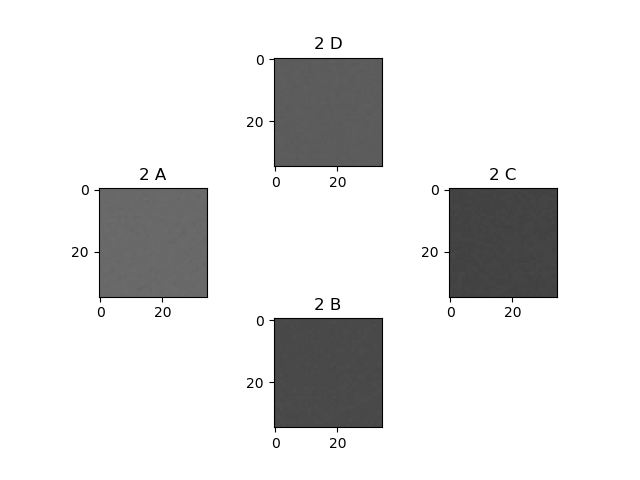

for segment  3
nx= 36
ny= 36
0 1 3.398111513964625
0 2 2.8802104277952574
0 3 3.8584489857322457
1 2 7.107623689945272
1 3 1.306836885883632
2 3 2.2032355513446134
Correlation score = 9.58179453986067



<IPython.core.display.Javascript object>


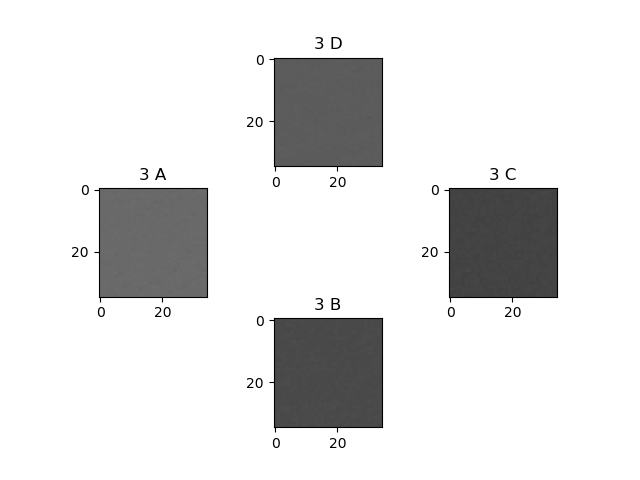

for segment  4
nx= 36
ny= 36
0 1 16.422039604466924
0 2 -76.0139693931065
0 3 -65.77191669771815
1 2 -44.16505597402877
1 3 -42.63874003189582
2 3 92.14206358897799
Correlation score = 150.44110527675056



<IPython.core.display.Javascript object>


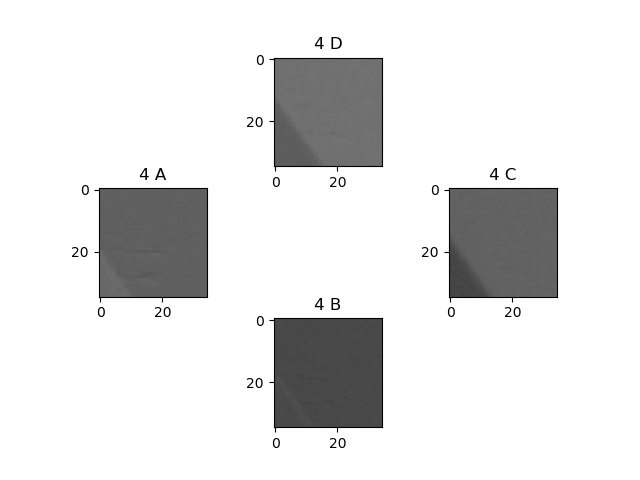

for segment  5
nx= 36
ny= 36
0 1 -0.9837364168813691
0 2 -89.36732309137608
0 3 -79.1666488830151
1 2 -24.372519009450542
1 3 -29.73912286510571
2 3 94.2646257792707
Correlation score = 156.90474579878304



<IPython.core.display.Javascript object>


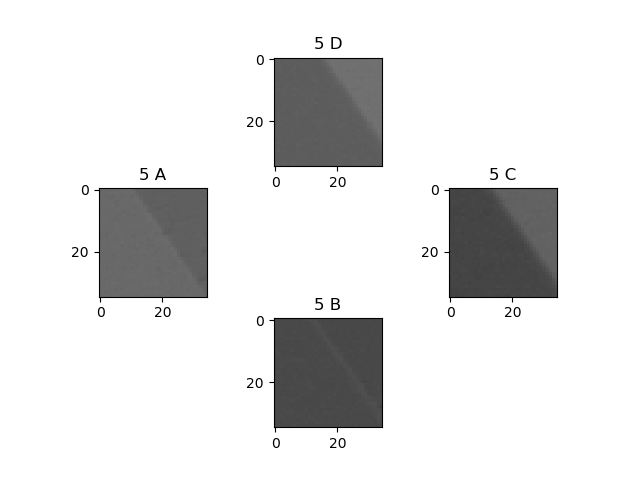

for segment  6
nx= 36
ny= 36
0 1 2.9428726362686333
0 2 1.8260132534300897
0 3 7.536459059184359
1 2 8.827353132672595
1 3 -1.319992049040626
2 3 10.941810031278093
Correlation score = 16.37622630537256



<IPython.core.display.Javascript object>


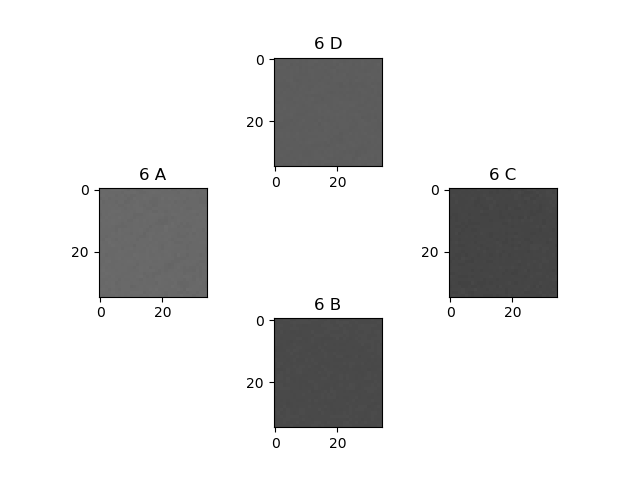

for segment  7
nx= 36
ny= 36
0 1 -0.6666407604554958
0 2 2.850304192823612
0 3 -1.7159092824151492
1 2 9.669602481801638
1 3 -17.139493752202664
2 3 9.824489000328805
Correlation score = 22.255269733616963



<IPython.core.display.Javascript object>


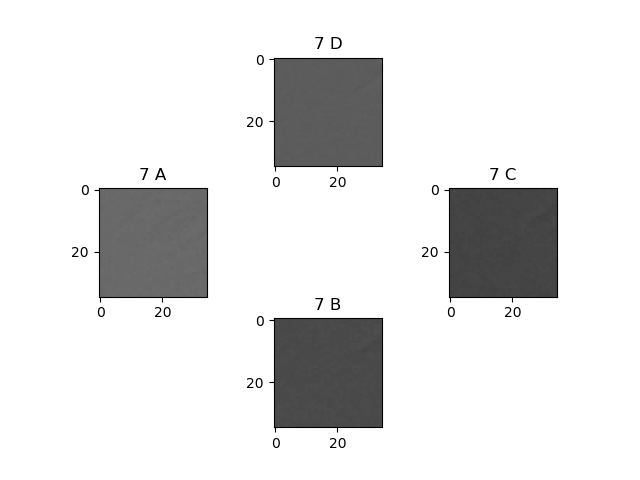

for segment  8
nx= 36
ny= 36
0 1 6.3769737390604275
0 2 9.207167665061984
0 3 5.853079747053832
1 2 11.377808608654808
1 3 8.531360911963422
2 3 14.048425855238744
Correlation score = 23.649380325118422



<IPython.core.display.Javascript object>


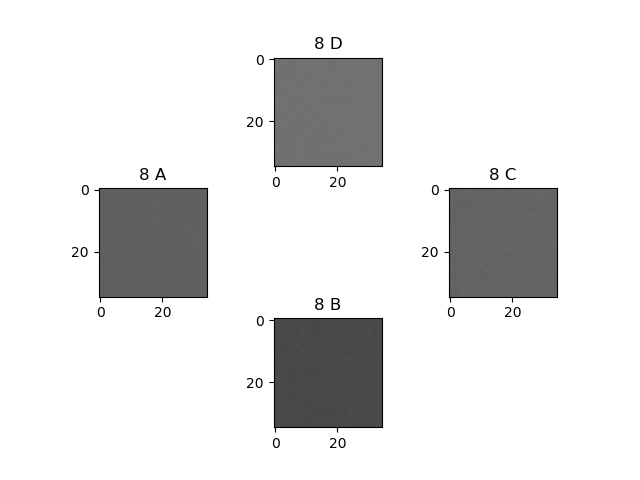

for segment  9
nx= 36
ny= 36
0 1 7.748720541806521
0 2 9.053878465993813
0 3 6.496688193375176
1 2 6.1042286927720095
1 3 -39.37871927728016
2 3 41.32184578076144
Correlation score = 58.98866349880688



<IPython.core.display.Javascript object>


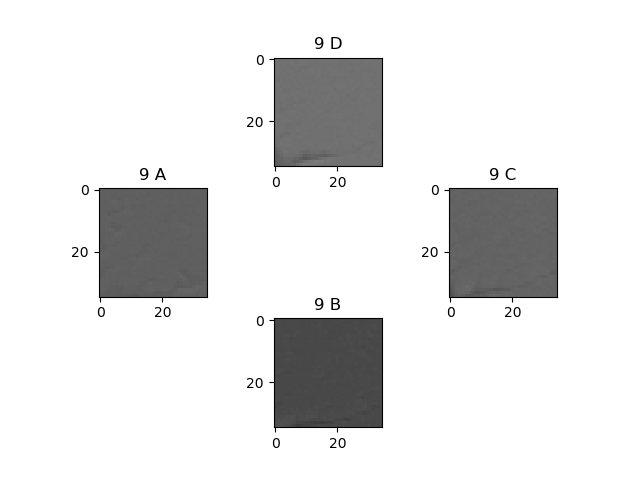

for segment  10
nx= 36
ny= 36
0 1 34.068413703447284
0 2 -77.88428565765835
0 3 -66.63523550836688
1 2 -9.812499705951495
1 3 -32.485726437132136
2 3 84.68903541028182
Correlation score = 141.3885202811032



<IPython.core.display.Javascript object>


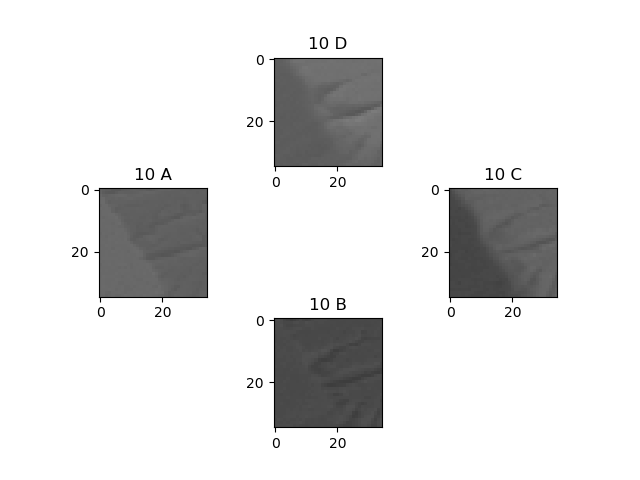

for segment  11
nx= 36
ny= 36
0 1 27.68852685847824
0 2 -87.12444385658371
0 3 -68.72196950234614
1 2 -3.906045530670791
1 3 -26.122369109569803
2 3 79.70465421784175
Correlation score = 141.88199178459215



<IPython.core.display.Javascript object>


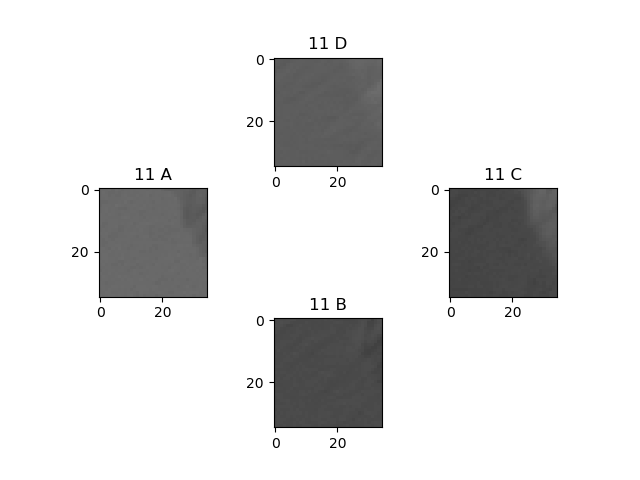

for segment  12
nx= 36
ny= 36
0 1 21.23168385213435
0 2 16.32018916760239
0 3 22.36282703363292
1 2 24.22201365586505
1 3 16.79205966911703
2 3 25.35026459160678
Correlation score = 52.23546817000939



<IPython.core.display.Javascript object>


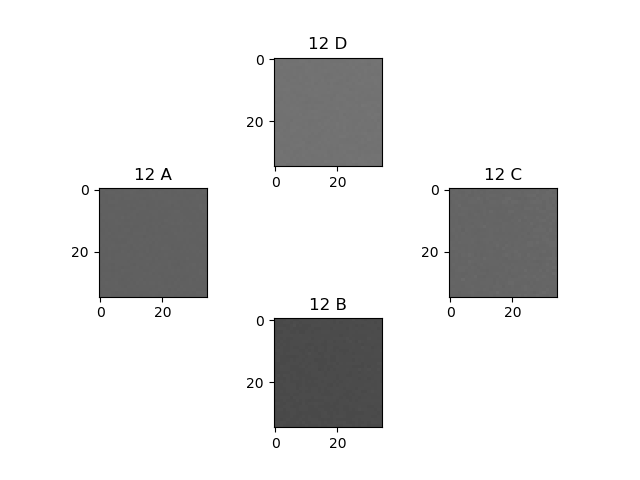

for segment  13
nx= 36
ny= 36
0 1 12.00145389548503
0 2 12.448351323289565
0 3 11.261947000664852
1 2 19.530160625788135
1 3 11.24118224058172
2 3 14.368347041587908
Correlation score = 33.764901087695264



<IPython.core.display.Javascript object>


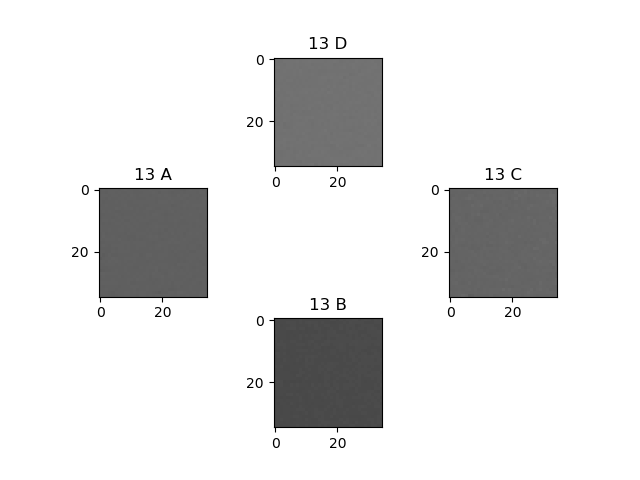

for segment  14
nx= 36
ny= 36
0 1 6.605668161262196
0 2 0.6384646284742246
0 3 18.239618536067574
1 2 36.12712795067305
1 3 16.05936560395669
2 3 47.93763464290063
Correlation score = 65.09850678780475



<IPython.core.display.Javascript object>


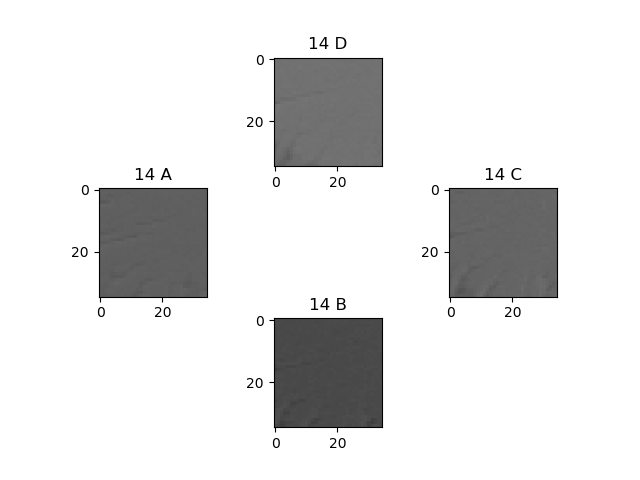

for segment  15
nx= 36
ny= 36
0 1 6.031096658671723
0 2 -35.95843605141626
0 3 -4.571244618852067
1 2 63.135455959677024
1 3 6.536252497107507
2 3 53.43986002250695
Correlation score = 90.74638594843772



<IPython.core.display.Javascript object>


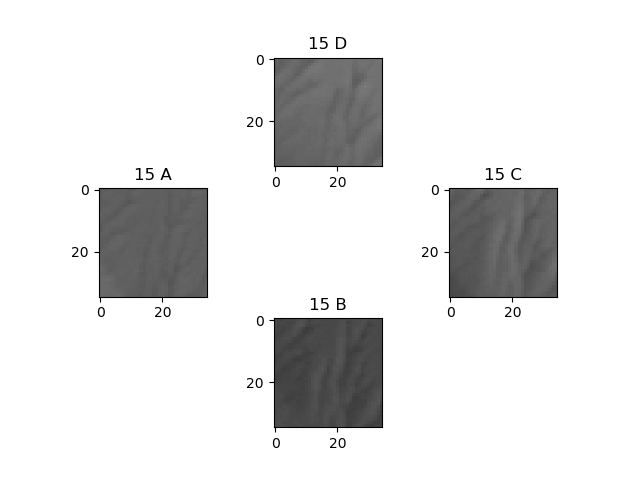

<IPython.core.display.Javascript object>


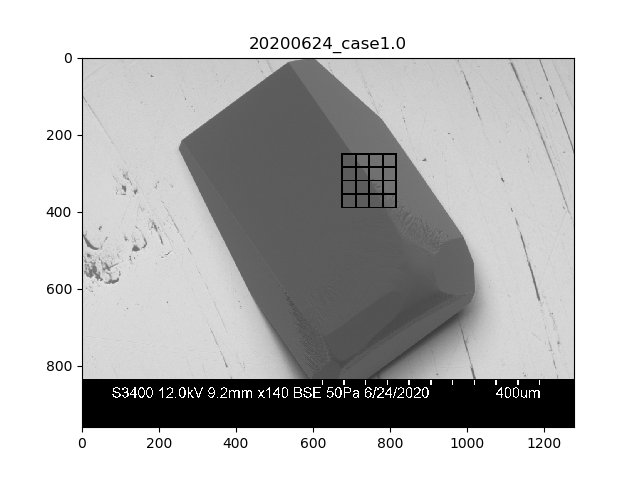

In [8]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [9]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../Case1.0 (calibration)/Calibration.nml


In [10]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [11]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [12]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [13]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [14]:
# Generic retrieval parameters
maxiter = 4
tolerance = 10

In [15]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [16]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 16 )
for 675 250
Observed intensities (detector B):
mean, max, min = 57.435102040816325 62.0 55.0
<diff>, std(diff), di2 = 0.2717850559328991 8.354086132896947 12206.859605987927
<diff>, std(diff), di2 = -2.0055758648551274 2.479834561384957 298.8366262582606
<diff>, std(diff), di2 = -2.1659580733633863 2.0359911882944606 22.122193177372466
<diff>, std(diff), di2 = -2.1801392121736054 1.99348783487932 3.0985187017605895

Segment: 1 ( 2 of 16 )
for 675 285
Observed intensities (detector B):
mean, max, min = 57.63755102040816 60.0 55.0
<diff>, std(diff), di2 = -0.22760269916914183 7.0034067042087065 8263.632297982826
<diff>, std(diff), di2 = -2.1816407247921865 1.7302563039738281 20.375138580182004
<diff>, std(diff), di2 = -2.235421155027713 1.619179970129297 0.015957685012101493
Noverlap = 36

Segment: 2 ( 3 of 16 )
for 675 320
Observed intensities (detector B):
mean, max, min = 57.82857142857143 60.0 56.0
<diff>, std(diff), di2 = -0.17535780120995811 6.93823126168140

140
140


<IPython.core.display.Javascript object>


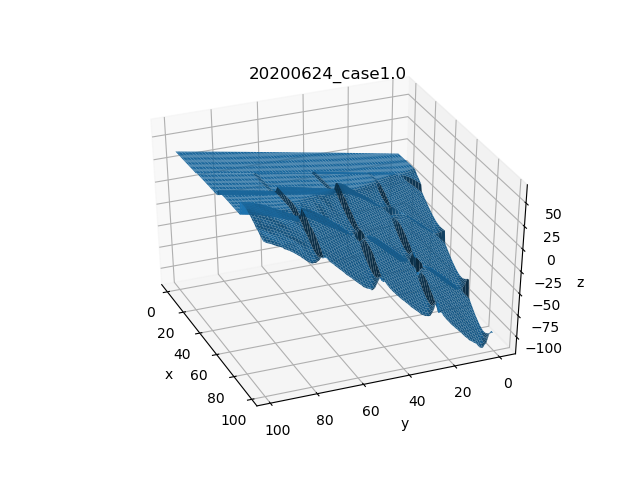

In [17]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [18]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments2_retrieved
